Loading cifar10 dataset...


[2025-05-28 18:02:26,755] INFO: Created CIFAR-10 loaders: 50000 train, 10000 val samples


Loading healer model...
❌ Healer model not found


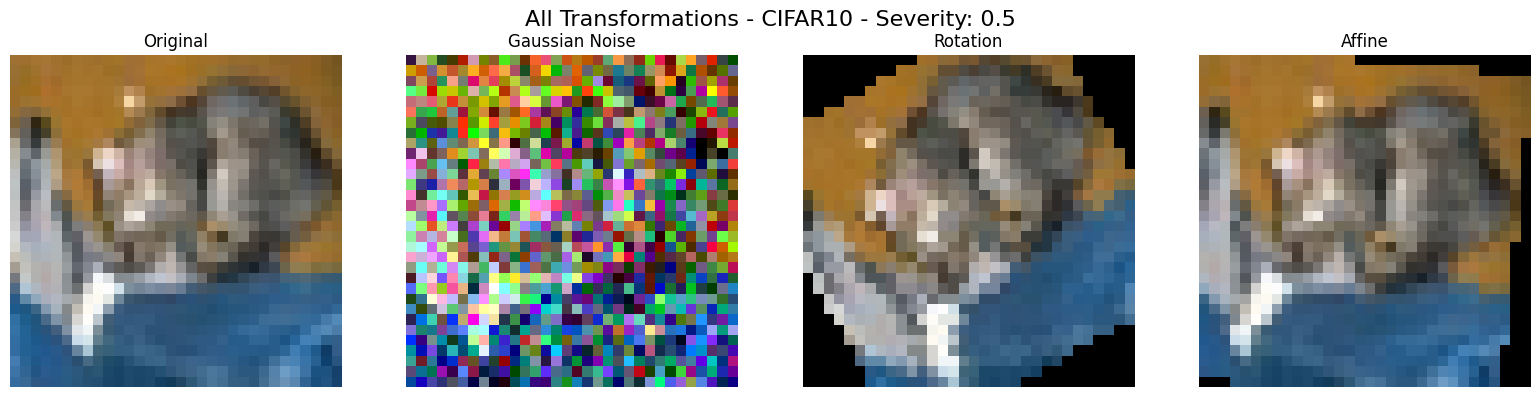

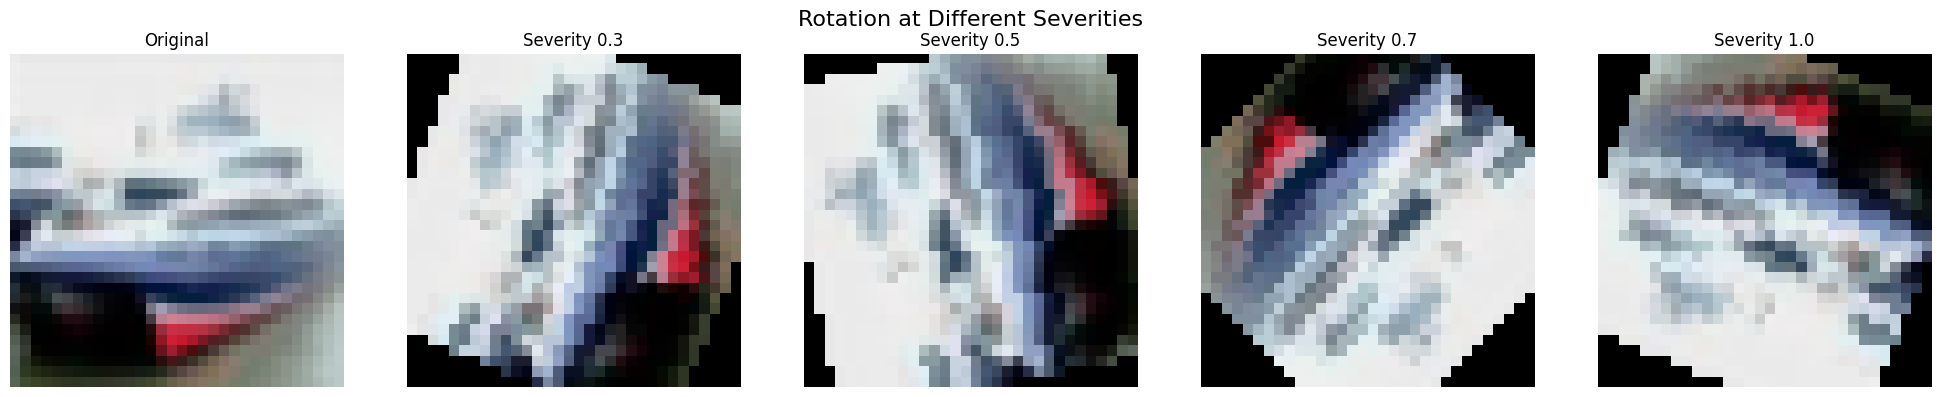

In [3]:
"""
Notebook-friendly functions for visualizing transformations and healer corrections
"""
import sys
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from config.config_loader import ConfigLoader
from data.data_loader import DataLoaderFactory
from data.continuous_transforms import ContinuousTransforms
from models.model_factory import ModelFactory


class TransformVisualizer:
    """Helper class for transformation visualization"""
    
    def __init__(self, dataset='cifar10', debug=True):
        """
        Initialize visualizer
        
        Args:
            dataset: 'cifar10' or 'tinyimagenet'
            debug: Use debug mode for faster loading
        """
        self.dataset = dataset
        self.debug = debug
        
        # Load configuration
        self.config = ConfigLoader()
        self.device = torch.device(self.config.get_device())
        
        # Create factories
        self.data_factory = DataLoaderFactory(self.config)
        self.model_factory = ModelFactory(self.config)
        
        # Load data
        print(f"Loading {dataset} dataset...")
        _, self.val_loader = self.data_factory.create_data_loaders(
            dataset, 
            with_normalization=False,
            with_augmentation=False
        )
        
        # Get normalization
        self.normalize = self.data_factory.get_normalization_transform(dataset)
        
        # Dataset-specific parameters
        if dataset == 'cifar10':
            self.mean = np.array([0.4914, 0.4822, 0.4465])
            self.std = np.array([0.2470, 0.2435, 0.2616])
            self.class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                               'dog', 'frog', 'horse', 'ship', 'truck']
        else:
            self.mean = np.array([0.485, 0.456, 0.406])
            self.std = np.array([0.229, 0.224, 0.225])
            self.class_names = None
        
        # Load healer model
        self.healer_model = None
        self.load_healer()
        
        # Get sample batch
        self.images, self.labels = next(iter(self.val_loader))
        
    def load_healer(self):
        """Load healer model if available"""
        print("Loading healer model...")
        checkpoint_dir = self.config.get_checkpoint_dir(self.dataset, use_debug_dir=self.debug)
        healer_path = checkpoint_dir / "bestmodel_healer" / "best_model.pt"
        
        if healer_path.exists():
            self.healer_model = self.model_factory.load_model_from_checkpoint(
                healer_path, 'healer', self.dataset, device=self.device
            )
            self.healer_model.eval()
            print("✅ Healer model loaded!")
        else:
            print("❌ Healer model not found")
    
    def show_single_transform(self, image_idx=0, transform_type='rotation', severity=0.5):
        """
        Show a single transformation with optional healer correction
        
        Args:
            image_idx: Index of image to use
            transform_type: Type of transformation ('gaussian_noise', 'rotation', 'affine')
            severity: Transformation severity (0.0-1.0)
        """
        # Get image
        original = self.images[image_idx]
        label = self.labels[image_idx].item()
        
        # Create transform engine
        transform_engine = ContinuousTransforms(severity=severity)
        
        # Apply transformation
        transformed, params = transform_engine.apply_transforms(
            original, 
            transform_type=transform_type,
            severity=severity,
            return_params=True
        )
        
        # Create figure
        num_cols = 3 if self.healer_model else 2
        fig, axes = plt.subplots(1, num_cols, figsize=(5*num_cols, 5))
        
        # Original
        self._show_image(axes[0], original, "Original")
        if self.class_names:
            axes[0].set_xlabel(f"Class: {self.class_names[label]}")
        
        # Transformed
        self._show_image(axes[1], transformed, f"{transform_type.title()}")
        axes[1].set_xlabel(self._get_param_text(transform_type, params))
        
        # Healer correction
        if self.healer_model:
            corrected = self._apply_healer(transformed)
            self._show_image(axes[2], corrected, "Healer Corrected")
            
            # Get prediction
            normalized = self.normalize(transformed).unsqueeze(0).to(self.device)
            with torch.no_grad():
                predictions, _ = self.healer_model(normalized, return_reconstruction=False, return_logits=False)
            
            if 'transform_type_logits' in predictions:
                pred_idx = torch.argmax(predictions['transform_type_logits'], dim=1).item()
                pred_type = transform_engine.transform_types[pred_idx]
                conf = torch.softmax(predictions['transform_type_logits'], dim=1)[0, pred_idx].item()
                axes[2].set_xlabel(f"Predicted: {pred_type} ({conf:.1%})")
        
        plt.suptitle(f"Transformation Demo - Severity: {severity}", fontsize=14)
        plt.tight_layout()
        plt.show()
    
    def show_all_transforms(self, image_idx=0, severity=0.5):
        """
        Show all transformation types for a single image
        
        Args:
            image_idx: Index of image to use
            severity: Transformation severity (0.0-1.0)
        """
        # Get image
        original = self.images[image_idx]
        label = self.labels[image_idx].item()
        
        # Create transform engine
        transform_engine = ContinuousTransforms(severity=severity)
        
        # Setup figure
        rows = 2 if self.healer_model else 1
        fig, axes = plt.subplots(rows, 4, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        # Show original
        self._show_image(axes[0, 0], original, "Original")
        if self.class_names:
            axes[0, 0].set_xlabel(f"Class: {self.class_names[label]}")
        
        # Transform types
        transform_types = ['gaussian_noise', 'rotation', 'affine']
        
        for idx, t_type in enumerate(transform_types):
            # Apply transformation
            transformed, params = transform_engine.apply_transforms(
                original, transform_type=t_type, severity=severity, return_params=True
            )
            
            # Show transformed
            self._show_image(axes[0, idx+1], transformed, t_type.replace('_', ' ').title())
            axes[0, idx+1].set_xlabel(self._get_param_text(t_type, params), fontsize=8)
            
            # Show healer correction if available
            if self.healer_model:
                corrected = self._apply_healer(transformed)
                self._show_image(axes[1, idx+1], corrected, "Healer Corrected")
                
                # Get prediction
                normalized = self.normalize(transformed).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    predictions, _ = self.healer_model(normalized, return_reconstruction=False, return_logits=False)
                
                if 'transform_type_logits' in predictions:
                    pred_idx = torch.argmax(predictions['transform_type_logits'], dim=1).item()
                    pred_type = transform_engine.transform_types[pred_idx]
                    conf = torch.softmax(predictions['transform_type_logits'], dim=1)[0, pred_idx].item()
                    color = 'green' if pred_type == t_type else 'red'
                    axes[1, idx+1].set_xlabel(f"Pred: {pred_type} ({conf:.1%})", 
                                             fontsize=8, color=color)
        
        # Reference in bottom left
        if self.healer_model:
            self._show_image(axes[1, 0], original, "Reference")
        
        plt.suptitle(f"All Transformations - {self.dataset.upper()} - Severity: {severity}", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def compare_severities(self, image_idx=0, transform_type='rotation'):
        """
        Compare different severity levels for a transformation
        
        Args:
            image_idx: Index of image to use
            transform_type: Type of transformation
        """
        original = self.images[image_idx]
        severities = [0.0, 0.3, 0.5, 0.7, 1.0]
        
        rows = 2 if self.healer_model else 1
        fig, axes = plt.subplots(rows, len(severities), figsize=(4*len(severities), 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, severity in enumerate(severities):
            # Create transform engine
            transform_engine = ContinuousTransforms(severity=severity)
            
            if severity == 0.0:
                # Show original
                self._show_image(axes[0, idx], original, "Original")
                if self.healer_model:
                    self._show_image(axes[1, idx], original, "Original")
            else:
                # Apply transformation
                transformed, params = transform_engine.apply_transforms(
                    original, transform_type=transform_type, severity=severity, return_params=True
                )
                
                self._show_image(axes[0, idx], transformed, f"Severity {severity}")
                axes[0, idx].set_xlabel(self._get_param_text(transform_type, params), fontsize=8)
                
                if self.healer_model:
                    corrected = self._apply_healer(transformed)
                    self._show_image(axes[1, idx], corrected, "Healer Corrected")
        
        plt.suptitle(f"{transform_type.title()} at Different Severities", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def _apply_healer(self, image):
        """Apply healer correction to an image"""
        # Normalize
        normalized = self.normalize(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            # Get predictions
            predictions, _ = self.healer_model(normalized, return_reconstruction=False, return_logits=False)
            
            # Apply correction
            corrected = self.healer_model.apply_correction(normalized, predictions)
            corrected = corrected[0].cpu()
        
        # Denormalize
        return self._denormalize(corrected)
    
    def _denormalize(self, tensor):
        """Denormalize tensor for visualization"""
        mean_t = torch.tensor(self.mean).view(3, 1, 1)
        std_t = torch.tensor(self.std).view(3, 1, 1)
        denormalized = tensor * std_t + mean_t
        return torch.clamp(denormalized, 0, 1)
    
    def _show_image(self, ax, tensor, title):
        """Display tensor as image"""
        img = tensor.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    
    def _get_param_text(self, transform_type, params):
        """Get parameter text for transformation"""
        if transform_type == 'gaussian_noise':
            return f"σ = {params['noise_std']:.3f}"
        elif transform_type == 'rotation':
            return f"angle = {params['rotation_angle']:.1f}°"
        elif transform_type == 'affine':
            return f"tx={params['translate_x']:.2f}, ty={params['translate_y']:.2f}\nshear=({params['shear_x']:.1f}°, {params['shear_y']:.1f}°)"
        return ""


# Example usage functions
def demo_cifar10():
    """Quick demo for CIFAR-10"""
    viz = TransformVisualizer('cifar10', debug=True)
    
    # Show all transforms for first image
    viz.show_all_transforms(image_idx=0, severity=0.5)
    
    # Compare severities
    viz.compare_severities(image_idx=1, transform_type='rotation')
    
    return viz


def demo_tinyimagenet():
    """Quick demo for TinyImageNet"""
    viz = TransformVisualizer('tinyimagenet', debug=True)
    
    # Show all transforms
    viz.show_all_transforms(image_idx=0, severity=0.7)
    
    return viz


if __name__ == '__main__':
    # Run CIFAR-10 demo
    viz = demo_cifar10()